In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. El objetivo de este ejercicio es actualizar nuestras creencias sobre los modelos causales
alternativos luego de observar un conjunto datos, P (Modelo|Datos).

Tengo r que es en que caja esta el premio, s es la caja que el presentador señala y c la caja que yo habia elegido.



### 1.1  Definir la distribucion de creencia conjunta como producto de las
distribuciones condicionales del modelo

In [5]:
#Primero defino probabilidades de los parametros, segun cada modelo

def pr(r): #igual en ambos
    return 1/3

def pc(c): #igual en ambos
    return 1/3

def ps_rM0(s,r): #modelo base
    return (r!=s) * 1/2

def ps_rcM1(s,r,c): #modelo Monty Hall
    if r!=c:
        return (s!=r) * (s!=c) * 1
    else:
        return (s!=r)*1/2

In [6]:
prcs_M = np.array([np.zeros((3,3,3)),np.zeros((3,3,3))])
h = np.arange(3)

for r in h:
    for c in h:
        for s in h:
            prcs_M[0,r,c,s] = pr(r) * pc(c) * ps_rM0(s,r)
            prcs_M[1,r,c,s] = pr(r) * pc(c) * ps_rcM1(s,r,c)

### 1.2 Mostrar que el producto de las predicciones a priori de la secuencia
de datos de un episodio es igual a la probabilidad conjunta a priori

In [7]:
def pc_M(c,m): #m=0 , c=1
    
    return np.sum(prcs_M[m,:,c,:])

def ps_cM(s,c,m):
    #P(s|c,M) = P(s,c|M) / p(c)
    return np.sum(prcs_M[m,:,c,s]) / pc_M(c,m)

def pr_scM(r,s,c,m):
    #P(r|s,c,M) = P(r,c,s|M)/P(c,s|M)
    return prcs_M[m,r,c,s]/np.sum(prcs_M[m,:,c,s])

In [8]:
def pEpisodio(c,s,r,m):
    #P(r,c,s|M) = p(c|M) * p(s|c,M) * p(r|s,c,M)
    if m==0:
        return pr(r) * pc(c) * ps_rM0(s,r)
    else:
        return pr(r) * pc(c) * ps_rcM1(s,r,c)
    #return pc_M(c,m) * ps_cM(s,c,m) * pr_scM(r,s,c,m)

pEpisodio(c=1,s=0,r=2,m=1) == prcs_M[1,2,1,0]

True

### 1.3. Simular datos con el modelo Monty Hall

In [9]:
def simularMontyHall(n_episodios,seed=0):
    np.random.seed(seed)
    datos = []
    h = np.arange(3)
    p_r = [pr(hr) for hr in h]
    p_c = [pc(hc) for hc in h]
    for t in range(n_episodios):
        r_ = np.random.choice(3,p=p_r)
        c_ = np.random.choice(3,p=p_c)
        p_s = [ps_rcM1(hs,r_,c_) for hs in h]
        s_ = np.random.choice(3,p=p_s)
        datos.append((c_,s_,r_))
    return datos

In [10]:
simulaciones = simularMontyHall(16)

### 1.4. Calcular la prediccion a priori que hace cada uno de los modelos
sobre la totalidad de la base de datos simulada

In [11]:
predicciones = [[1],[1]]

for (c,s,r) in simulaciones:
    for m in range(2):
        predicciones[m].append(pEpisodio(c,s,r,m))

pDatos_M0, pDatos_M1 = np.prod(predicciones,axis=1)


In [12]:
predDatos_M0 = predicciones[0] #probabilidad de cada episodio para cada modelo!!
predDatos_M1 = predicciones[1]


ambas son muy cercanas a 0, pero el modelo base da e^-21 y el modelo Monty Hall da e^-17

### 1.5. Expresar intuitivamente la diferencia de desempeno predictivo de
los modelos

Una idea puede ser expresarlo como logaritmos!! 
Bayes Factor: log(P_m1/P_m0)

Como la diferencia es en ordenes de magnitud, medimos eso

In [13]:
#Con profe
log_evidencia_M0 = np.log10(pDatos_M0)
log_evidencia_M1 = np.log10(pDatos_M1)
#Diferencia de ordenes de magnitud
dif = log_evidencia_M1 - log_evidencia_M0
#cantidad de creencia que preserva M1 sobre M0
10**(dif)

4095.999999999973

In [14]:
# def bayes_factor():
#     return math.log10(p_m1/p_m0)
# bayes_factor()

Otra idea es la Media Geometrica / Prediccion Tipica.

P(datos|M) = p(d1|M) p(d2|d1,M) = prod [p(d1|M)P(d2|M)]^1/N

Lo hacemos con logaritmo

In [15]:
#Media Geometrica
media_geom_M1 = 10**(log_evidencia_M1/(len(simulaciones)*3))
media_geom_M0 = 10**(log_evidencia_M0/(len(simulaciones)*3))
print(media_geom_M1,media_geom_M0)

0.4537674406297909 0.38157141418444396


In [16]:
# o capaz asi, mejor asi. 
log_p_datos_M0 = np.log10(predDatos_M0)
prediccion_tipica_datos_M0= 10**(np.sum(log_p_datos_M0)/(len(simulaciones)*3))
pred_conjunta_datos_M0 = prediccion_tipica_datos_M0**(len(simulaciones)*3)

log_p_datos_M1 = np.log10(predDatos_M1)
prediccion_tipica_datos_M1= 10**(np.sum(log_p_datos_M1)/(len(simulaciones)*3))
pred_conjunta_datos_M1 = prediccion_tipica_datos_M1**(len(simulaciones)*3)

pred_conjunta_datos_M0,pred_conjunta_datos_M1

(8.234550899283281e-21, 3.372872048346434e-17)

### 1.6. Calcular la prediccion de los datos con la contribucion de todos los
modelos.

In [17]:
def pM(m):
    return 1/2

pDatosM = [np.cumprod(predDatos_M0) * pM(0) , np.cumprod(predDatos_M1) * pM(1)]
pDatos = pDatosM[0] + pDatosM[1]

pM_Datos = pDatosM/pDatos

In [18]:
pM_Datos

array([[5.00000000e-01, 3.33333333e-01, 3.33333333e-01, 2.00000000e-01,
        1.11111111e-01, 5.88235294e-02, 5.88235294e-02, 5.88235294e-02,
        3.03030303e-02, 1.53846154e-02, 7.75193798e-03, 3.89105058e-03,
        1.94931774e-03, 1.94931774e-03, 9.75609756e-04, 4.88042948e-04,
        2.44081035e-04],
       [5.00000000e-01, 6.66666667e-01, 6.66666667e-01, 8.00000000e-01,
        8.88888889e-01, 9.41176471e-01, 9.41176471e-01, 9.41176471e-01,
        9.69696970e-01, 9.84615385e-01, 9.92248062e-01, 9.96108949e-01,
        9.98050682e-01, 9.98050682e-01, 9.99024390e-01, 9.99511957e-01,
        9.99755919e-01]])

### 1.8. Graficar el valor del posterior a medida que se observan nuevos
episodios

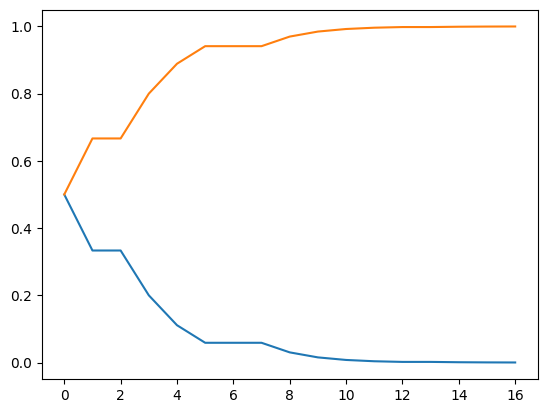

In [19]:
plt.plot(pM_Datos[0])
plt.plot(pM_Datos[1])

### 1.9. Leer los datos NoMontyHall.csv, proponer un modelo alternativo
superior a Monty Hall y el modelo Base, y evaluarlo en funci´on del
desempe˜no predictivo.



In [20]:
datosNoMonty = pd.read_csv("Materiales1/datos/NoMontyHall.csv")

In [21]:
datosNoMonty

,c,s,r
0,2,0,1
1,1,2,1
2,1,0,2
3,2,0,1
4,2,1,0
...,...,...,...
1995,1,2,0
1996,2,0,1
1997,1,0,2
1998,0,1,2


P(r, c, s, a, p|M2) = P(r)P(c)P(s|r, M0)^(1−a) P(s|r, c, M1)^(a) P(a|p)P(p)

Crear un modelo alternativo que tenga un desempeno similar al modelo Monty Hall. 
Calcular la secuencia de predicciones de los tres modelos en esta nueva base de datos (Modelo Base, Monty Hall y Alternativo). 
Calcular la diferencia de desempeno predictivo en  ́orden de magnitud entre los modelos. 
Calcular la media geometrica de las predicciones de los diferentes modelos. 
Graficar el posterior de los tres modelos en los primeros 60 episodios.

In [22]:
''' 
La idea es modelar la p como un listado discreto de probabilidades.
Ir integrando....
'''

' \nLa idea es modelar la p como un listado discreto de probabilidades.\nIr integrando....\n'

In [23]:
import random
import numpy as np

In [24]:


def pp_M2():
    return random.choice(np.linspace(0,1,100))

def pa_pM2(a,p):
    if a ==1:
        return p
    else:
        return 1-p

def prcsap_M2(s,r,c,a,p):
    return pr(r)*pc(c)*ps_rM0(s,r)**(1-a) * ps_rcM1(s,r,c)**a *pa_pM2(a,p) * p



In [47]:
#Predicciones
def pEpisodio_mas_modelos(c,s,r,m):
    #P(r,c,s|M) = p(c|M) * p(s|c,M) * p(r|s,c,M)
    if m==0:
        return pr(r) * pc(c) * ps_rM0(s,r)
    elif m == 1:
        return pr(r) * pc(c) * ps_rcM1(s,r,c)
    else:
        return sum([prcsap_M2(s,r,c,a,p) for a in [0,1] for p in [i**-1 for i in range(1,10)]])
        

In [48]:
predicciones = [[1],[1],[1]]

for (c,s,r) in datosNoMonty.values:
    for m in range(3):
        predicciones[m].append(pEpisodio_mas_modelos(c,s,r,m))

pDatos_M = [np.cumprod(predicciones[0]) * 1/3 , np.cumprod(predicciones[1]) * 1/3, np.cumprod(predicciones[2]) * 1/3]
pDatos = pDatos_M[0] + pDatos_M[1] + pDatos_M[2]

pM_Datos = pDatos_M/pDatos

C:\Users\admin\AppData\Local\Temp\ipykernel_7684\1167365379.py:10: RuntimeWarning: invalid value encountered in divide
  pM_Datos = pDatos_M/pDatos


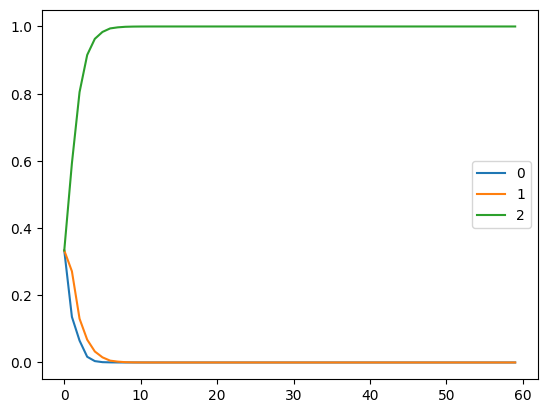

In [52]:
plt.plot(pM_Datos[0][0:60])
plt.plot(pM_Datos[1][0:60])
plt.plot(pM_Datos[2][0:60])
plt.legend([0,1,2])

Hacer con matriz, integrar por a=0,a=1 y varias p.

## Ejercicio 2


### 2.1. Generar datos con el modelo AcausaB

In [26]:
pA_MAB = np.array([0.5,0.5])
pAB_MAB = np.array([[0.95,0.05],[0.05,0.95]]) #A,B

pB_MBA = np.array([0.5,0.5])
pBA_MBA = np.array([[0.95,0.05],[0.05,0.95]]) #B,A

def gen_datos_AcausaB(n=16,seed=0):
    np.random.seed(seed)
    datos = []
    for i in range(n):
        a = np.random.choice([0,1],p=pA_MAB)
        b = np.random.choice([0,1],p=pAB_MAB[a])
        datos.append((a,b))
    return datos

datosAcausaB = gen_datos_AcausaB()



In [27]:
datosAcausaB

[(1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (0, 0)]

### 2.2. Evaluar el desempeno predictivo de los modelos causales alterna-
tivos sobre los datos sint ́eticos generados en el punto anterior



Es decir, quiero p(Datos|Modelo) = prod p(a_i,b_i | Modelo)

Pero p(a_i,b_i | Modelo) depende del modelo:

- p(a_i,b_i | mAB) = p(b_i | a_i) * p(a_i|mAB)
- p(a_i,b_i | mA) = p(a_i | b_i) * p(b_i|mBA)

Una vez tengo p(Datos|Modelo) puedo compararlos

In [28]:


def pB_A_MAB(A,B): #posterior modelo AB
    return pAB_MAB[A,B] * pA_MAB[A]

def pA_B_MBA(A,B): #posterior modelo BA
    return pBA_MBA[B,A] * pB_MBA[B]

def pred_AB_M(A,B,m): #m=0 es AB, m=1 es BA
    if m==0:
        return pB_A_MAB(A,B)
    else:
        return pA_B_MBA(A,B)

predicciones_modelos_AB_BA=[[],[]]
for (a,b) in datosAcausaB:
    for m in range(2):
        predicciones_modelos_AB_BA[m].append(pred_AB_M(a,b,m))
predicciones_modelos_AB_BA

[[0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475],
 [0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475,
  0.475]]

In [29]:
pDatosAB_MAB = np.prod(predicciones_modelos_AB_BA[0])
pDatosAB_MBA = np.prod(predicciones_modelos_AB_BA[1])
pDatosAB_MAB,pDatosAB_MBA

(6.715799997738117e-06, 6.715799997738117e-06)

Ambos modelos tienen igual desempeño!!!

### 2.3. Actualizar la creencia respecto de los modelos causales alternativos luego de ver los datos.

In [30]:
pDatos_AcausaB_Modelos = [np.cumprod(predicciones_modelos_AB_BA[0] )* 1/2,np.cumprod(predicciones_modelos_AB_BA[1] )* 1/2]
pDatos_AcausaB = pDatos_AcausaB_Modelos[0] + pDatos_AcausaB_Modelos[1]
pModelos_DatosAcausaB = pDatos_AcausaB_Modelos/pDatos_AcausaB
pModelos_DatosAcausaB

array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5]])

### 2.4 Conclusiones


Son exactamente iguales!!!
En los datos originales siempre caen en 1,1 o 0,0, quizas ahi esta el problema!!

## 3. Modelos polinomiales de complejidad creciente.

In [31]:
import Materiales1.ModeloLineal as modeloLineal
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc

### 3.1. Generar 20 datos alrededor de una per´ıodo de una sinoidal

In [32]:



x_datos = np.arange(-0.5,0.5+1/19,1/19)
y_datos = np.sin(2*np.pi*x_datos) + sc.stats.norm.rvs(0,0.1,len(x_datos))

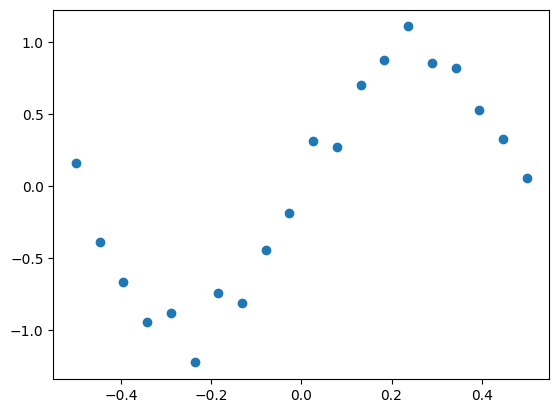

In [33]:
plt.scatter(x_datos,y_datos)

### 3.2. Graficar el valor de m´axima verosimilitud obtenido por los modelos polinomiales de grado 0 a 9


In [34]:
for grado in range(10):
    np.sum(y_datos - sum())

TypeError: sum() takes at least 1 positional argument (0 given)